# Data Wrangling of one file tracking data

The dataset contains 5min of tracking information for each player in a club, recording their precise x and y coordinates.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
from scipy.stats import zscore
import matplotlib.cm as cm
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import tracking data from one recording of 5 minutes

In [28]:
data = pd.read_csv("tracking_data.txt", sep=",", header=None)
data.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]
data.head()

frame_number  track_id  role    xbox   ybox     w     h  xworld  yworld  \
0             0        61     0  1596.2  265.0  62.1  97.6    47.6    48.1   
1             0        62     1  1646.2  146.1  31.3  58.7    47.8    31.9   
2             0        63     0  1590.5  165.0  28.6  61.5    46.3    35.2   
3             0        64     3   855.9  292.0  34.5  51.7    19.3    33.5   
4             0        65     1  1770.2   95.4  19.4  38.7    52.4    13.6   

    IoU  
0  0.00  
1  0.00  
2  0.00  
3  0.00  
4  0.05

`role` feature:
* 0/1 - players
* 2 - ref
* 3/4 - goalies
* -1 - unused detections (non-players and non-refs)
  

`xworld` and `yworld` are in meters measured from the back left corner flag (from the point of view of the camera).

In [29]:
data.shape

(28565, 10)

In [30]:
data["track_id"].nunique()

30

We have 30 unique tracking IDs, representing only the outfield players and referees.

As a result, there may be instances where non-player or non-referee objects are detected, or cases where an object is reassigned or re-identified. This can happen in highly occluded situations (in football these are corners or free kicks, with a large number of players on a small area of the pitch)

In [31]:
data["role"].value_counts()

role
 0    12469
 1    12455
 2     1250
 4     1250
 3     1134
-1        7
Name: count, dtype: int64

remove the unnecessary columns

In [32]:
data = data.drop( ["xbox", "ybox", "w", "h"], axis=1)

In [33]:
data[(data["frame_number"] == 0) & (data["role"] == 0)]

frame_number  track_id  role  xworld  yworld   IoU
0              0        61     0    47.6    48.1  0.00
2              0        63     0    46.3    35.2  0.00
8              0        69     0    55.6    36.8  0.01
13             0        74     0    80.3    38.9  0.00
14             0        75     0    62.4    36.4  0.00
15             0        76     0    78.6    53.1  0.00
19             0        80     0    75.7    31.1  0.09
20             0        81     0    71.5    28.7  0.00
22             0        83     0    53.7    18.7  0.00
24             0        85     0    56.8    25.8  0.01

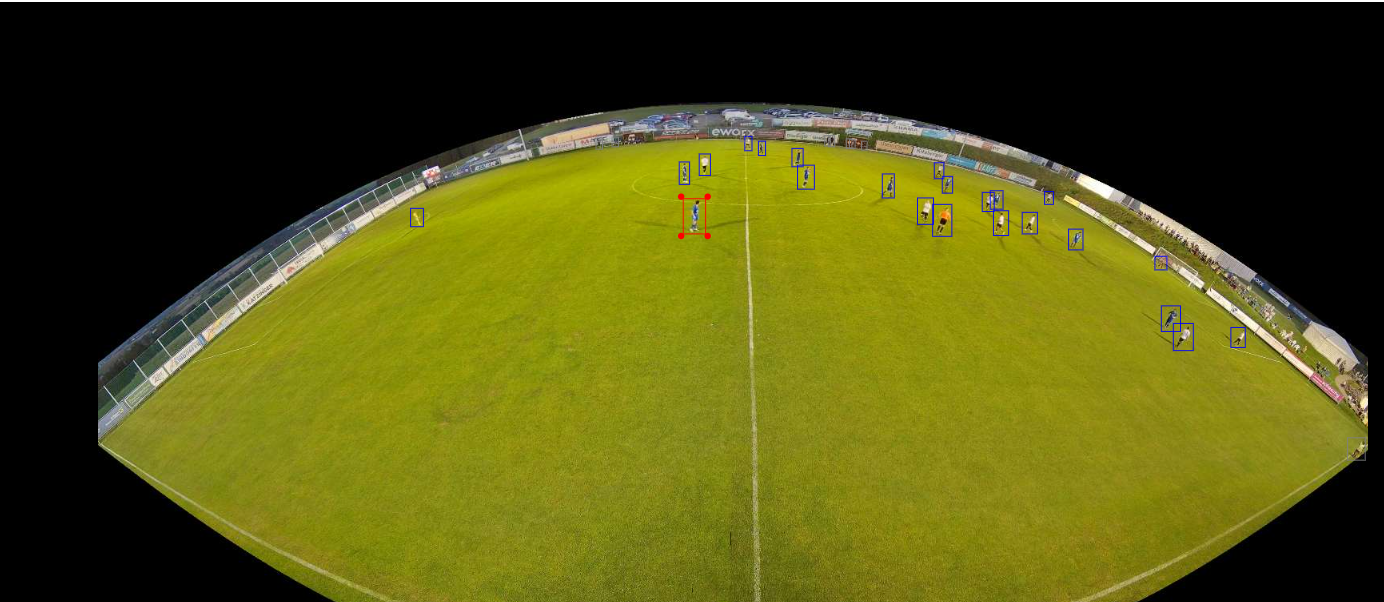

# EDA

In [34]:
data_team0 = data[data["role"] == 0]
data_team0["track_id"].nunique()   


10

plot the first 5min of tracking/runnning data from eacg player

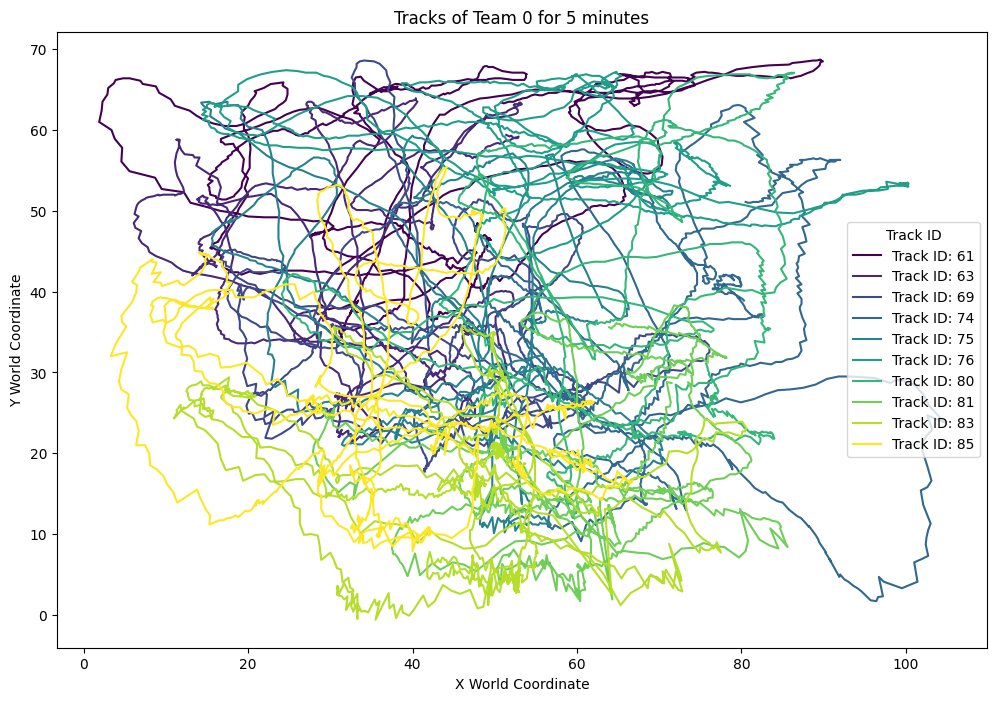

In [35]:
# Get unique track IDs
unique_tracks = data_team0['track_id'].unique()

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_tracks)))
for idx, track_id in enumerate(unique_tracks):
    track_data = data_team0[data_team0['track_id'] == track_id]
    plt.plot(track_data['xworld'], track_data['yworld'], color=colors[idx], linestyle='-', markersize=1, label=f'Track ID: {track_id}')

plt.title('Tracks of Team 0 for 5 minutes')
plt.xlabel('X World Coordinate')
plt.ylabel('Y World Coordinate')
plt.legend(title='Track ID')
plt.show()

In [36]:
data[(data["frame_number"] >= 0) & (data["track_id"] == 61)]

frame_number  track_id  role  xworld  yworld  IoU
0                 0        61     0    47.6    48.1  0.0
30                6        61     0    47.8    48.1  0.0
53               12        61     0    47.9    48.5  0.0
76               18        61     0    47.9    48.5  0.0
99               24        61     0    47.9    48.5  0.0
...             ...       ...   ...     ...     ...  ...
28466          7470        61     0    52.3    63.5  0.0
28488          7476        61     0    51.9    63.5  0.0
28510          7482        61     0    51.7    63.5  0.0
28532          7488        61     0    51.1    63.3  0.0
28554          7494        61     0    50.8    63.4  0.0

[1241 rows x 6 columns]

In [37]:
player_61 = data[(data["track_id"] == 61) & (data["role"] == 0)]
player_61_xy = pd.DataFrame({'x': player_61["xworld"], 'y': player_61["yworld"]})

In [38]:
def create_pitch(df):
    # mirror the y-axis
    df['y'] = 68 - df['y']
 
    fig, ax = plt.subplots(figsize=(12, 8))

    
    ax.set_facecolor('green')
    plt.plot([0, 0, 105, 105, 0], [0, 68, 68, 0, 0], color="white")
    plt.plot([16.5, 16.5, 0, 0, 16.5], [21.16, 46.84, 46.84, 21.16, 21.16], color="white")
    plt.plot([105, 105 - 16.5, 105 - 16.5, 105, 105], [21.16, 21.16, 46.84, 46.84, 21.16], color="white")
    plt.plot([0, 6, 6, 0], [30.9, 30.9, 37.1, 37.1], color="white")
    plt.plot([105, 105 - 6, 105 - 6, 105], [30.9, 30.9, 37.1, 37.1], color="white")

    center_circle = plt.Circle((52.5, 34), 9.15, color="white", fill=False)
    ax.add_patch(center_circle)

    plt.plot([52.5, 52.5], [0, 68], color="white")
    plt.plot(11, 34, 'wo')  
    plt.plot(94, 34, 'wo')  
    plt.plot(52.5, 34, 'wo')  
    plt.plot([0, 0], [30.9, 37.1], color="white", linewidth=8)  
    plt.plot([105, 105], [30.9, 37.1], color="white", linewidth=8)  

    ax.set_xlim(-5, 110)
    ax.set_ylim(-5, 73)
    ax.set_aspect('equal')

   
    plt.xticks([])
    plt.yticks([])

    
    plt.title('Player tracking - 5min', fontsize=20)
    

    sns.kdeplot(x=df['x'], y=df['y'], ax=ax, shade=True, cmap="coolwarm", n_levels=30, alpha=0.7, label='Movement Density')
    plt.plot(df['x'], df['y'], color='blue', linestyle='-', marker='o', markersize=3, label='Player Runline')
    plt.scatter(df['x'].iloc[0], df['y'].iloc[0], color='green', s=100, label='Start Point', edgecolor='black')
    plt.scatter(df['x'].iloc[-1], df['y'].iloc[-1], color='red', s=100, label='End Point', edgecolor='black')

    plt.legend()
    plt.grid(False)
    plt.show()

plot the first 5min of tracking data of player with `player_id` 61 with lineplot and heatmap

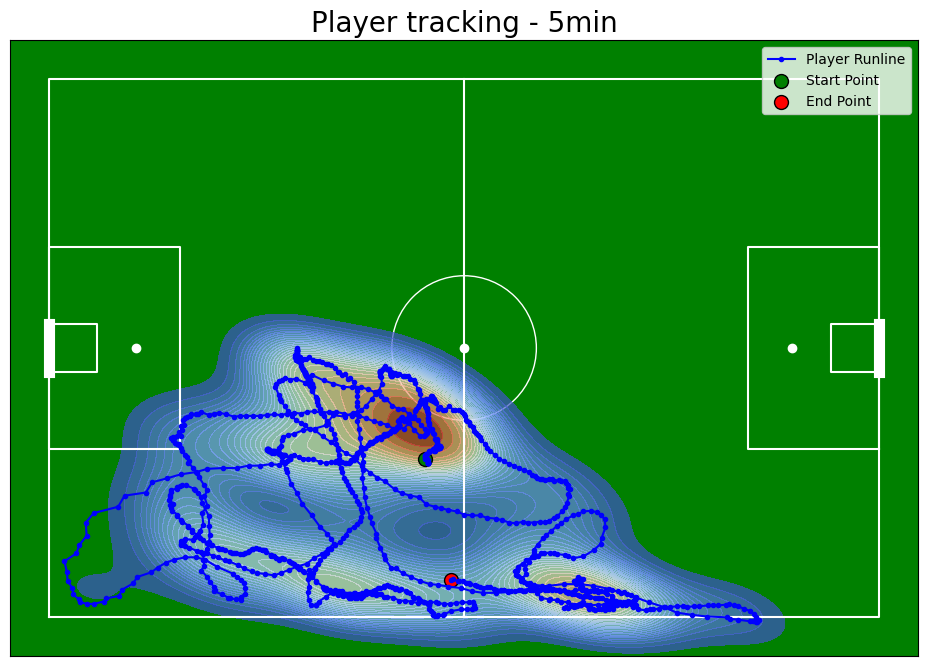

In [39]:
create_pitch(player_61_xy)

Add convex hull

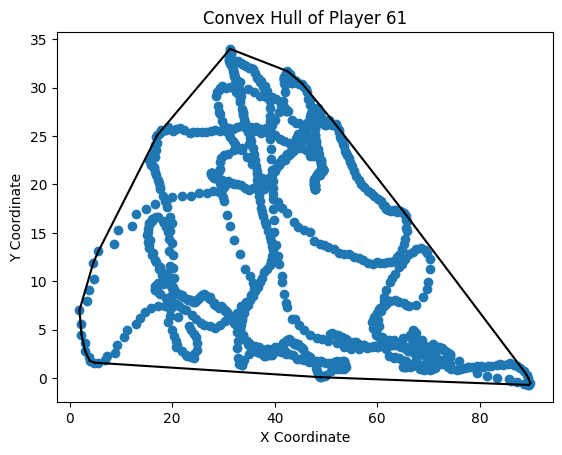

In [40]:
points = player_61_xy[['x', 'y']].values
hull = ConvexHull(points)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Convex Hull of Player 61')
plt.show()

In [41]:
players_role_0 = data[data["role"] == 0]

In [42]:
players_role_0

frame_number  track_id  role  xworld  yworld   IoU
0                 0        61     0    47.6    48.1  0.00
2                 0        63     0    46.3    35.2  0.00
8                 0        69     0    55.6    36.8  0.01
13                0        74     0    80.3    38.9  0.00
14                0        75     0    62.4    36.4  0.00
...             ...       ...   ...     ...     ...   ...
28556          7494        75     0    59.8    53.6  0.00
28557          7494        69     0    54.1    49.5  0.00
28559          7494        83     0    49.2    29.3  0.00
28560          7494        74     0    80.5    51.1  0.00
28561          7494        81     0    63.9    35.6  0.00

[12469 rows x 6 columns]

In [43]:
plt.figure(figsize=(12, 10))

# Define a color map to assign different colors to each player
color_map = cm.get_cmap("tab20", len(players_role_0['track_id'].unique()))


for i, player_id in enumerate(players_role_0['track_id'].unique()):
    player_data = players_role_0[players_role_0['track_id'] == player_id]
    points = player_data[['xworld', 'yworld']].values  
    
    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        
  
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], '-', color=color_map(i), alpha=0.9)
    
plt.title('Convex Hulls for Each Player of Team 0')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(loc="best", title="Players")
plt.show()


/var/folders/6t/2kykm1l51vv3mrsbvhz5jznc0000gn/T/ipykernel_1450/804973175.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("tab20", len(players_role_0['track_id'].unique()))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [44]:
players_role_0.groupby('frame_number')
players_role_0

frame_number  track_id  role  xworld  yworld   IoU
0                 0        61     0    47.6    48.1  0.00
2                 0        63     0    46.3    35.2  0.00
8                 0        69     0    55.6    36.8  0.01
13                0        74     0    80.3    38.9  0.00
14                0        75     0    62.4    36.4  0.00
...             ...       ...   ...     ...     ...   ...
28556          7494        75     0    59.8    53.6  0.00
28557          7494        69     0    54.1    49.5  0.00
28559          7494        83     0    49.2    29.3  0.00
28560          7494        74     0    80.5    51.1  0.00
28561          7494        81     0    63.9    35.6  0.00

[12469 rows x 6 columns]

# Role discovery using minimum entropy data partitions
according to Alina Bialkowski, Patrick Lucey et al. 2014. Large-scale analysis of soccer matches using spatiotemporal
tracking data. In IEEE International Conference on Data Mining

Next in order to get certain role clusters for each player we process the tracking data  using K-Means and linear sum assignments (Hungarian algorithm). It normalizes positions, initializes roles with K-Means, and iteratively refines them by minimizing a cost matrix based on Gaussian probability distributions for each role. Gaussian parameters are updated as roles converge, and visualizations illustrate the evolving and final role clusters.

/var/folders/6t/2kykm1l51vv3mrsbvhz5jznc0000gn/T/ipykernel_1450/4252114904.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['xworld_norm', 'yworld_norm']] = df.groupby('frame_number')[['xworld', 'yworld']].transform(
/var/folders/6t/2kykm1l51vv3mrsbvhz5jznc0000gn/T/ipykernel_1450/4252114904.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['xworld_norm', 'yworld_norm']] = df.groupby('frame_number')[['xworld', 'yworld']].transform(
/var/folders/6t/2kykm1l51vv3mrsbvhz5jznc0000gn/T/ipykernel_145

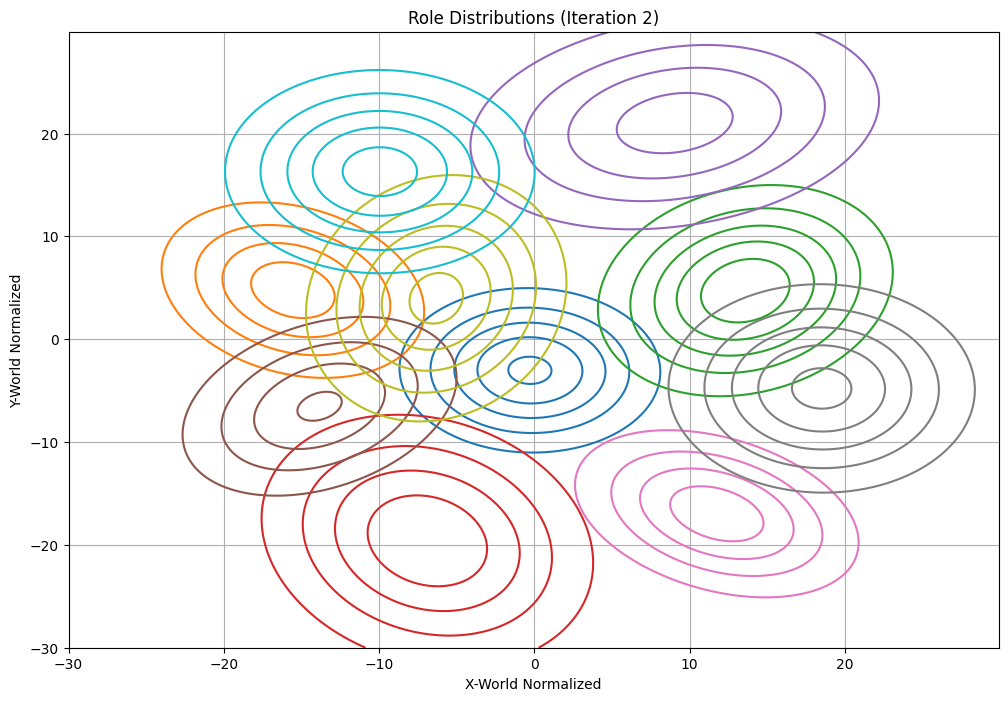

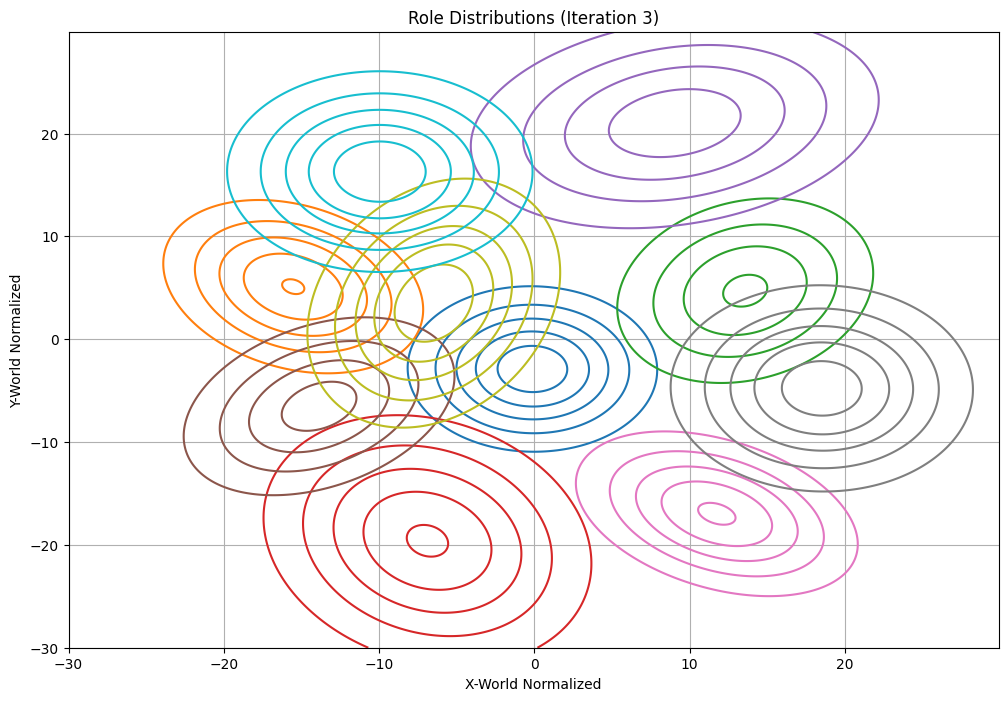

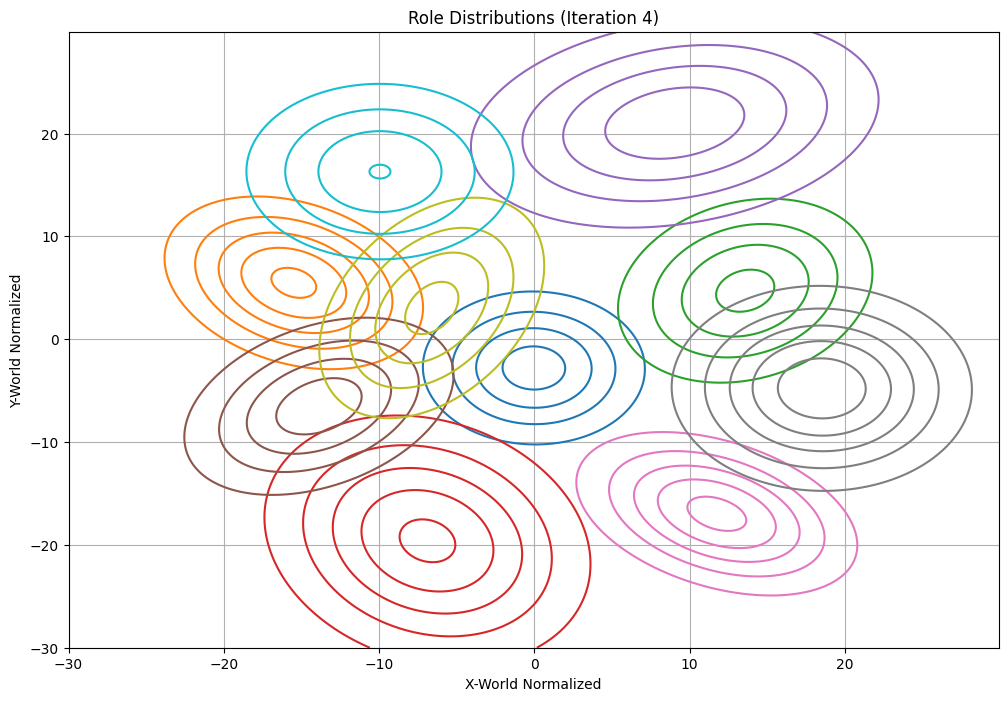

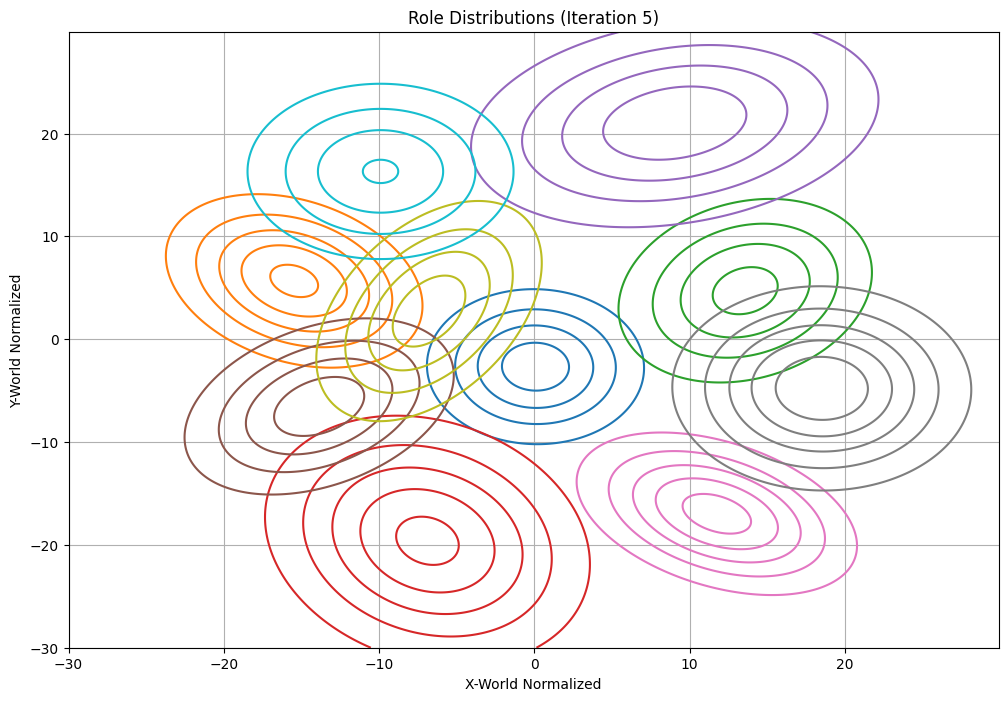

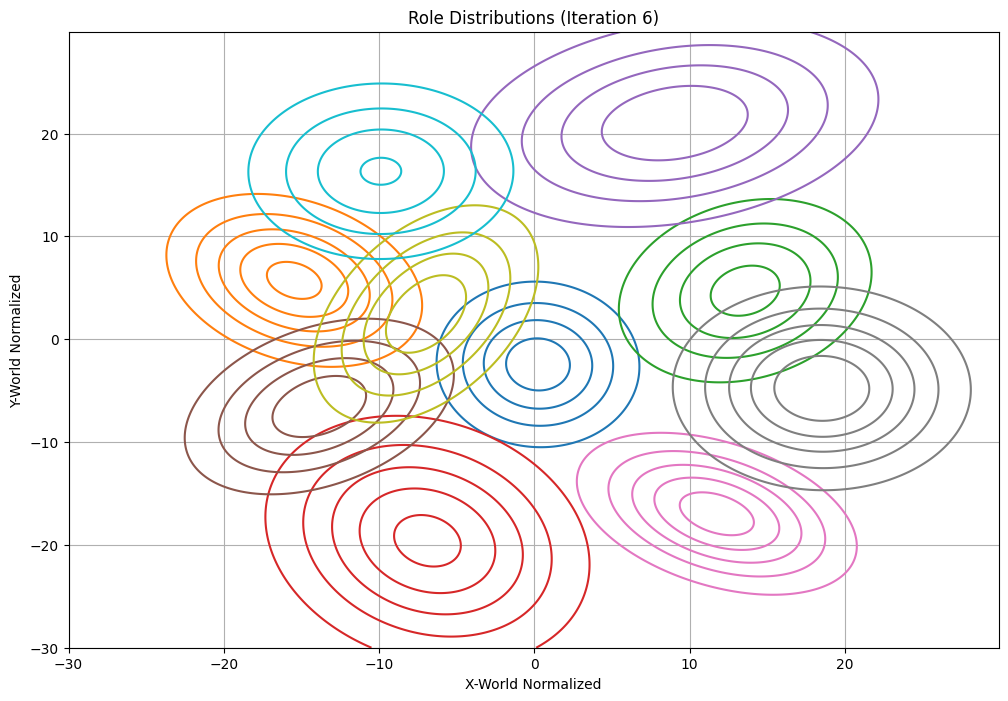

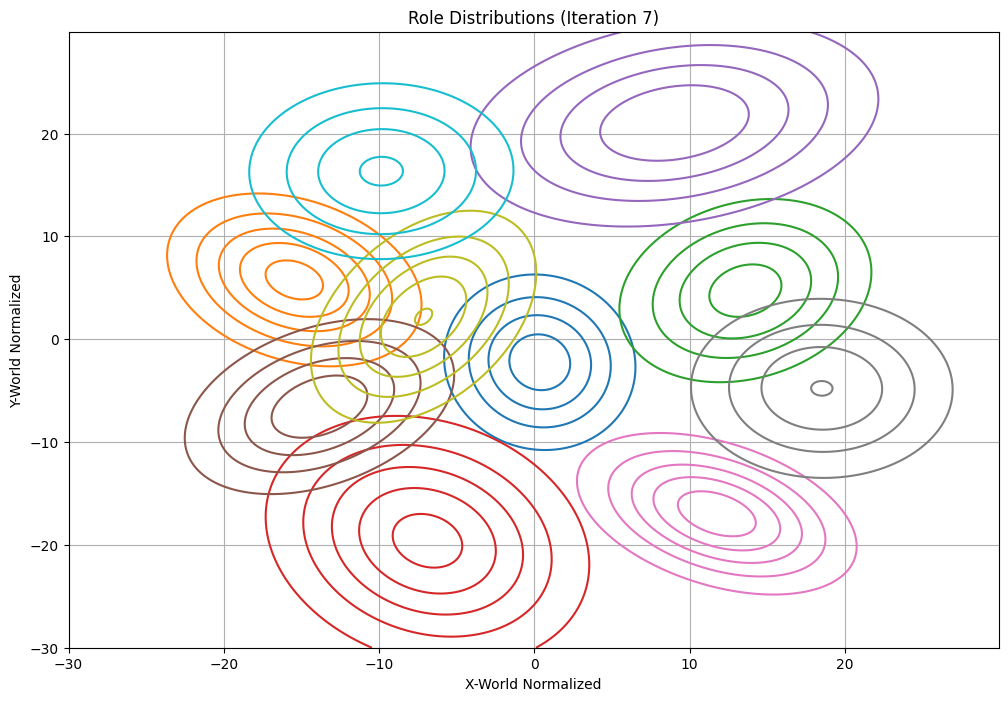

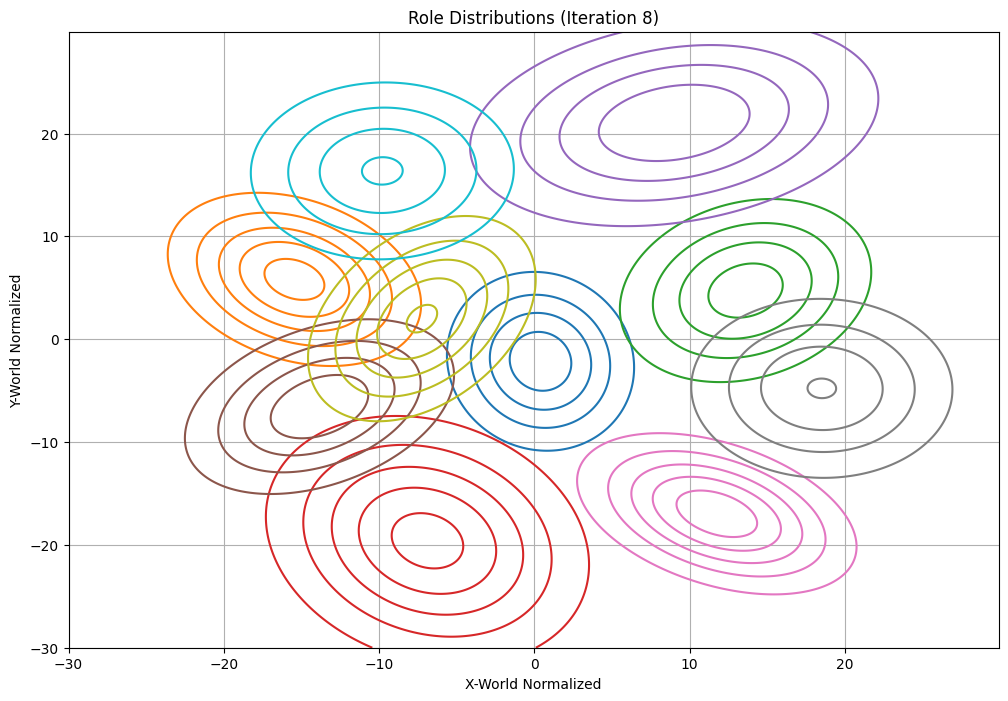

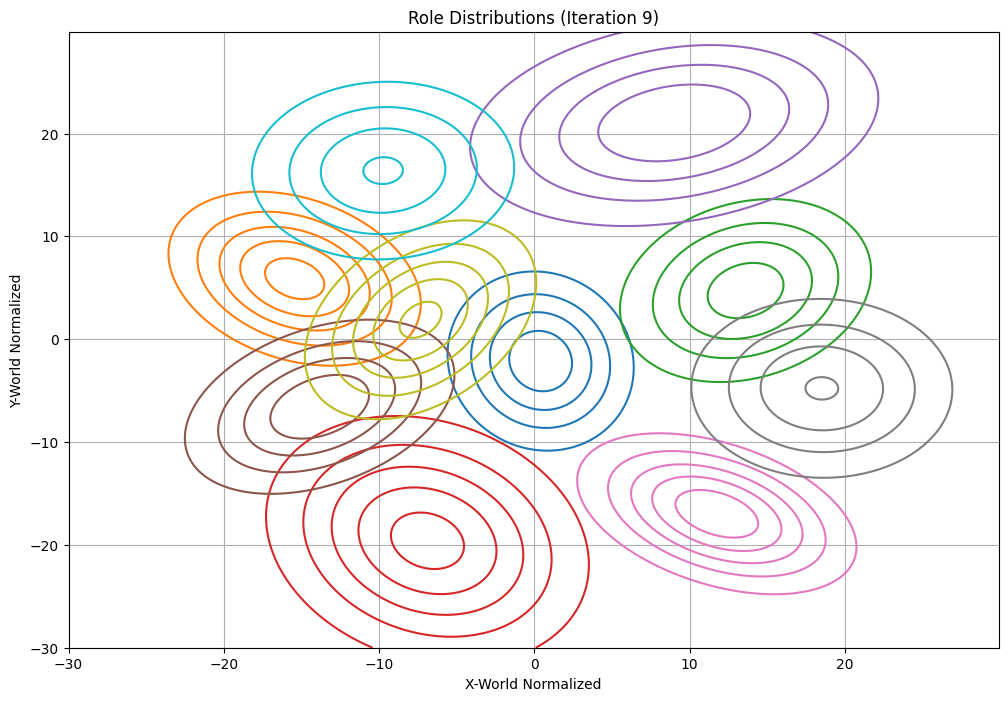

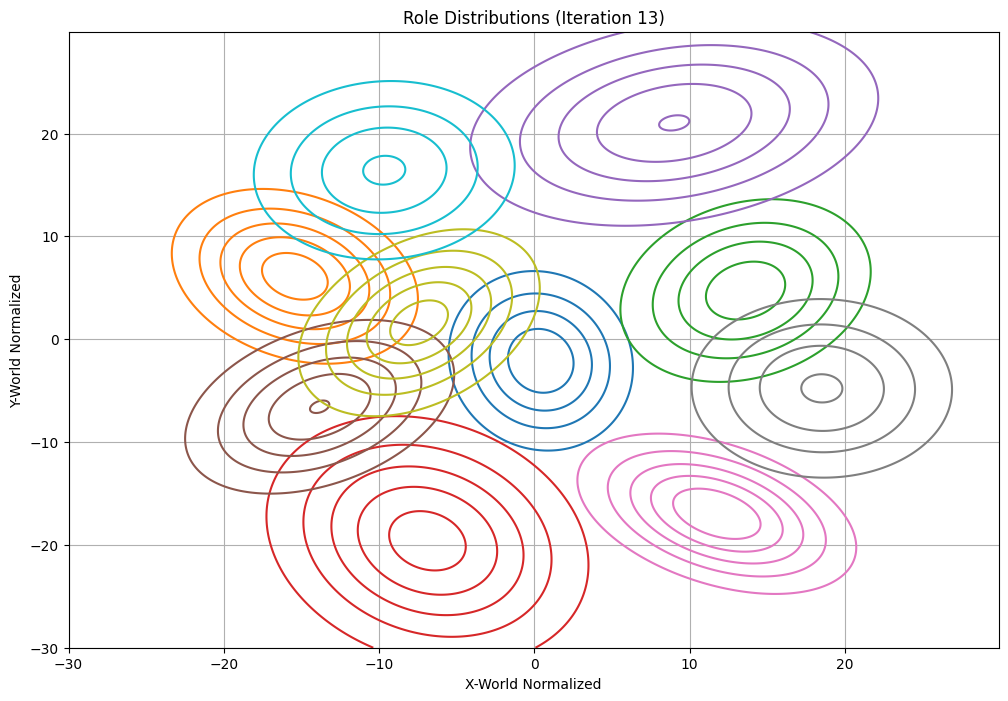

Final iteration: 13


In [45]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

# Normalize tracking data
def normalize_tracking_data(df):
    df[['xworld_norm', 'yworld_norm']] = df.groupby('frame_number')[['xworld', 'yworld']].transform(
        lambda x: x - x.mean()
    )
    return df


# Assign initial specialized roles using K-Means
def initialize_roles_with_kmeans(df, n_roles):
    kmeans = KMeans(n_clusters=n_roles, random_state=42)
    normalized_positions = df[['xworld_norm', 'yworld_norm']].values
    df['specialized_role'] = kmeans.fit_predict(normalized_positions)
    initial_means = kmeans.cluster_centers_
    return df, initial_means

# Create a cost matrix and use Hungarian algorithm
# Compute cost matrix based on log probabilities with separation bias
def compute_cost_matrix(positions, role_pdfs, separation_bias=1.0):
    
    n_positions = len(positions)
    n_roles = len(role_pdfs)
    cost_matrix = np.zeros((n_positions, n_roles))

    for i, pos in enumerate(positions):
        for j, pdf in enumerate(role_pdfs):
            # Negative log-probability for cost, with a small separation bias
            cost_matrix[i, j] = -np.log(pdf.pdf(pos) + 1e-8) + separation_bias * np.linalg.norm(pos - pdf.mean)
    return cost_matrix

# Iterative role updates
def update_roles(df, initial_means, separation_bias=2.0, cov_decay_factor=0.1, overlap_threshold=0.1):
    unique_roles = np.unique(df['specialized_role'])
    # Initialize role PDFs with a large covariance
    role_pdfs = {
        role: multivariate_normal( # Multivariate normal distribution
            mean=initial_means[role], cov=np.eye(2) * 20
        ) for role in unique_roles
    }
    colors = [plt.cm.tab10(i % 10) for i in range(len(unique_roles))]

    max_iterations = 20
    iteration = 0
    converged = False

    # Iteratively assign roles and refine PDFs
    while not converged and iteration < max_iterations:
        prev_assignments = df['specialized_role'].copy()
        new_role_positions = {role: [] for role in unique_roles}
        
        for _, frame_data in df.groupby('frame_number'):
            positions = frame_data[['xworld_norm', 'yworld_norm']].values
            cost_matrix = compute_cost_matrix(positions, [role_pdfs[role] for role in unique_roles], separation_bias)
            row_ind, col_ind = linear_sum_assignment(cost_matrix) # Hungarian algorithm
            df.loc[frame_data.index, 'specialized_role'] = [unique_roles[j] for j in col_ind]

            for i, j in zip(row_ind, col_ind):
                new_role_positions[unique_roles[j]].append(positions[i])

        for role, positions in new_role_positions.items():
            if positions:
                positions = np.array(positions)
                mean = positions.mean(axis=0)
                cov_decay = max(cov_decay_factor, 10 / (iteration + 1))
                cov = np.cov(positions.T) + np.eye(2) * cov_decay
                role_pdfs[role] = multivariate_normal(mean=mean, cov=cov)

        iteration += 1
        converged = np.array_equal(prev_assignments.values, df['specialized_role'].values)

        plt.figure(figsize=(12, 8))
        x, y = np.mgrid[-30:30:.1, -30:30:.1]
        pos = np.dstack((x, y))
        for role, pdf in role_pdfs.items():
            plt.contour(x, y, pdf.pdf(pos), levels=5, colors=[colors[role]])
        plt.title(f'Role Distributions (Iteration {iteration})')
        plt.xlabel('X-World Normalized')
        plt.ylabel('Y-World Normalized')
        plt.grid()
        plt.show()

    print("Final iteration:", iteration)
    return df, role_pdfs


players_role_0 = normalize_tracking_data(players_role_0)

n_roles = 10  
players_role_0, initial_means = initialize_roles_with_kmeans(players_role_0, n_roles)

# Iteratively assign roles and refine PDFs
players_role_0, role_pdfs = update_roles(players_role_0, initial_means, separation_bias=3.0)



plot the role-clusters in another format  

/var/folders/6t/2kykm1l51vv3mrsbvhz5jznc0000gn/T/ipykernel_1450/4046912697.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(roles))


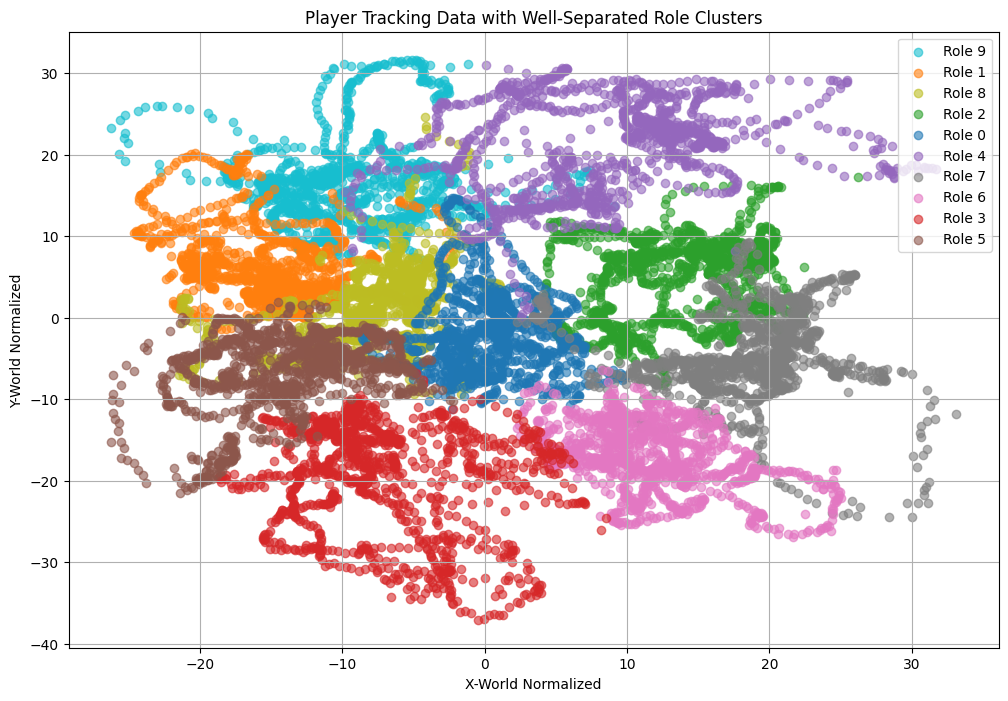

In [46]:
# Visualize final results
def plot_tracking_data(df):
    plt.figure(figsize=(12, 8))
    roles = df['specialized_role'].unique()
    colors = plt.cm.get_cmap("tab10", len(roles))

    for role in roles:
        role_data = df[df['specialized_role'] == role]
        plt.scatter(role_data['xworld_norm'], role_data['yworld_norm'], label=f'Role {role}', alpha=0.6, color=colors(role))

    plt.title('Player Tracking Data with Well-Separated Role Clusters')
    plt.xlabel('X-World Normalized')
    plt.ylabel('Y-World Normalized')
    plt.legend()
    plt.grid()
    plt.show()
# Plot the final tracking data
plot_tracking_data(players_role_0)

# All files
The entire dataset consists of 512897 datapoints.

In [47]:
file_paths = glob.glob('xy data/*.txt')
tracking_data = pd.concat((pd.read_csv(file, sep=",", header=None) for file in file_paths), ignore_index=True)
tracking_data.columns = ["frame_number", "track_id", "role", "xbox", "ybox", "w", "h", "xworld", "yworld", "IoU"]
tracking_data.info

<bound method DataFrame.info of         frame_number  track_id  role    xbox    ybox     w      h  xworld  \
0                  0       144     3   784.3   293.8  30.6   45.3    24.1   
1                  0       145    -1   725.6  1398.3  98.1  110.3    45.2   
2                  0       146     2  1494.2    11.3  17.1   29.7    48.7   
3                  0       147     0  1633.9   216.4  30.4   60.7    54.6   
4                  0       148     2  2542.9   294.3  32.8   43.9    88.7   
...              ...       ...   ...     ...     ...   ...    ...     ...   
512892          7494       659     1  2263.6   183.5  28.6   40.5    87.5   
512893          7494       653     1  2350.7   223.3  26.9   39.9    90.0   
512894          7494       662     0  2278.9   250.6  33.2   52.5    79.8   
512895          7494       655     1  2269.0   226.0  24.2   41.9    82.2   
512896          7494       675     4  2692.0   374.3  36.1   42.3   105.8   

        yworld   IoU  
0         34.2  0.00

In [48]:
tracking_data.shape

(512897, 10)

In [49]:
tracking_data["track_id"].nunique()

464

In [50]:
tracking_data["role"].value_counts()

role
 1      221990
 0      221469
 2       27990
 4       19862
 3       19752
 155       507
 166       506
 400       361
 396       345
-1         115
Name: count, dtype: int64

At fis2 and stv2 we have unclear roles

In [51]:
tracking_data[tracking_data["role"] == 400]

frame_number  track_id  role   xbox   ybox      w      h  xworld  \
190022           400       400   400  400.0  400.0  400.0  400.0   400.0   
190042           400       400   400  400.0  400.0  400.0  400.0   400.0   
190062           400       400   400  400.0  400.0  400.0  400.0   400.0   
190084           400       400   400  400.0  400.0  400.0  400.0   400.0   
190105           400       400   400  400.0  400.0  400.0  400.0   400.0   
...              ...       ...   ...    ...    ...    ...    ...     ...   
198121           400       400   400  400.0  400.0  400.0  400.0   400.0   
198144           400       400   400  400.0  400.0  400.0  400.0   400.0   
198166           400       400   400  400.0  400.0  400.0  400.0   400.0   
198188           400       400   400  400.0  400.0  400.0  400.0   400.0   
198211           400       400   400  400.0  400.0  400.0  400.0   400.0   

        yworld    IoU  
190022   400.0  400.0  
190042   400.0  400.0  
190062   400.0  400.0  
190084   400.0  400.0  
190105   400.0  400.0  
...        ...    ...  
198121   400.0  400.0  
198144   400.0  400.0  
198166   400.0  400.0  
198188   400.0  400.0  
198211   400.0  400.0  

[361 rows x 10 columns]